# Experiment 6A (Chapter 6)

This notebook covers Experiment 6A and the proceeding content relevant to this experiment. This includes the code and explanation to generate Figures 6.1-6.2 and 6.4-6.7.

==========================================================================
* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

*This Jupyter notebook should only be distributed to members of the "Fundamentals of Active Inference" reading group hosted by the Active Inference Institute.*

Package versions:
* matplotlib==3.5.3
* numpy==1.21.5
* pyro-ppl==1.8.4
* pytorch==1.13.1
* scipy==1.7.3
* sympy==1.9

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torch

from mpl_toolkits.mplot3d import Axes3D
# from pyro.distributions import Normal, MultivariateNormal
from scipy.integrate import odeint
from scipy.signal import convolve
from sympy import Symbol, Poly
from torch.autograd.functional import hessian, jacobian

plt.rcParams.update({
    "text.usetex": True,
    "figure.dpi": 120})

mpl.style.use("seaborn-deep")

## Figure 6.1 - Visualizing dynamical systems

Throughout this chapter, and in the rest of the book, we will be investigating generative processes that are dynamic - they change over time. It is important to get a good visual understanding of the system we are modeling, so the first part of this notebook will demonstrate how to plot and think about these **dynamical systems**. 

We will be frequently utilizing physics metaphors throughout this notebook and the remainder of the chapter. Namely, we will assume that if we have some state $x$, then the **time-derivative** of $x$, defined as $\dot{x} = \frac{dx}{dt}$, metaphorically represents the "velocity" of the state. Environmental states are not necessarily physical objects but since they change over time we can think of them, and model them, as if they were and as if they have **equations of motion**. In this case the interpretation is that $x$ is a position (just the state itself) and $\dot{x}$ is the *change* in that position over time, equivalent to the concept of velocity.

First, let's start by defining how states change over time with the function `x_dot()` alongside the range of $x$ over which we will plot the function. 

In [2]:
def x_dot(x, t=None):
    return x**3/500 - (x**2/6) + 30

x_range = np.arange(-25, 100, 0.01)

**Note**: The reason for including `t=None` as an argument to `x_dot()` will be clear in a moment.

Plotting this function over a given range of $x$ is easily accomplished in `Matplotlib` with something like `ax.plot(x_range, x_dot(x_range))`. Before we do that, we will discuss a second issue. Namely, we want to solve the **initial-value problem** for $\dot{x}$. This problem asks: "Given an ordinary differential equation (ODE), like $\dot{x}$), how do we *integrate* it to get $x$ and see how $x$ changes as a function of time". This is a very common problem, so common in fact that specific ODE solver exist for this type of problem. 

One convenient ODE solver is included in the `SciPy` package. This function is called `odeint()` ("ordinary differential equation integrator"). It will determine how $x$ changes over time given a first-order differential equation like $\dot{x}$. Thus, by specifying some time interval of interest (which explains why we need to include `t` as an argument to `x_dot()`), and some *initial value* from which we want to start the system off, we can see how it will evolve over time. Dynamical systems are very sensitive to initial conditions and their trajectories can look very different depending on the starting state at $t=0$, for the system.

There are many methods for solving initial-value problems, some more accurate than others in specific circumstances. In Chapter 5 we used *Euler's method*. Typically, in the code simulations and experiments we will Euler's method. But for some cases when we just want to quickly see what $x$ looks like, `odeint()` is quicker and more convenient. Under the hood, `odeint()` uses a solver called `LSODA` which is described in [1].

In [3]:
t_range = np.arange(0, 8, 0.01)
x_t = odeint(x_dot, y0=[0, 10, 20, 30], t=t_range) 

In this code we have told `odeint()` that we wish to solve the function `x_dot()` using four different initial values, $0, 10, 20, 30$, in order to see how each trajectory looks. Finally, we also pass in the time range of consideration. We are going to add a few other bells and whistles to the plot. These pieces will be explained in a moment.

In [4]:
x = Symbol('x')
roots = Poly( x**3/500 - (x**2/6) + 30).nroots()

In [5]:
def add_fixed_point(where: float, stable: bool):
    if stable: 
        axes[1].scatter(where, 0, c="black", zorder=8)
    else:
        axes[1].scatter(where, 0, c="white", ec='black', zorder=8)
        
def add_flows(where: list, direc: list):
    for pos, arr in zip(where, direc):
        axes[1].plot(pos, 0, marker=arr, ms=10, c="black")

<Figure size 720x480 with 0 Axes>

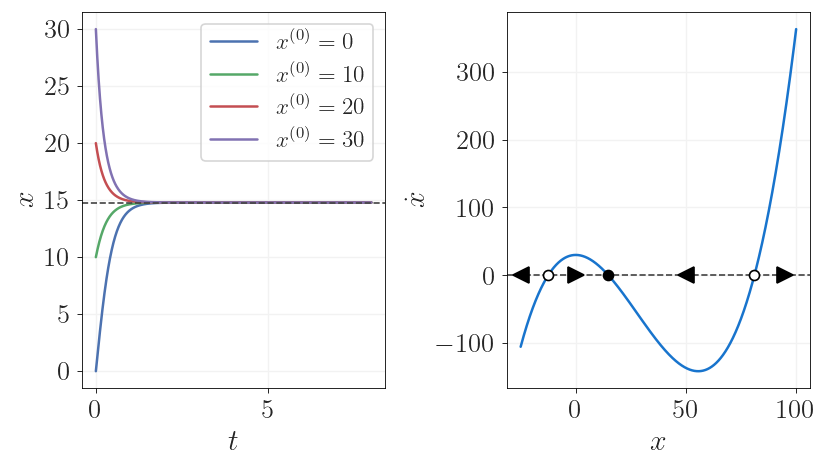

In [8]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1, 2, facecolor=(1,1,1), figsize=(7,4))

axes[0].plot(t_range, x_t[:, 0], label=r"$x^{(0)} = 0$")
axes[0].plot(t_range, x_t[:, 1], label=r"$x^{(0)} = 10$")
axes[0].plot(t_range, x_t[:, 2], label=r"$x^{(0)} = 20$")
axes[0].plot(t_range, x_t[:, 3], label=r"$x^{(0)} = 30$")
axes[0].axhline(y=roots[1], lw=1, ls="--", c="#424242")

axes[1].plot(x_range, x_dot(x_range), c="#1874CD")
axes[1].axhline(y=0, lw=1, ls="--", c="#424242")
add_fixed_point(roots[0], False)
add_fixed_point(roots[1], True)
add_fixed_point(roots[2], False)
add_flows(where=[0, -25, 50, 95], direc=[">", "<", "<", ">"])

axes[0].set_xlabel(r"$t$", fontsize=18)
axes[0].set_ylabel(r"$x$", fontsize=18)
axes[1].set_xlabel(r"$x$", fontsize=18)
axes[1].set_ylabel(r"$\dot{x}$", fontsize=18)

# Subplot legends
axes[0].legend(frameon=True, fontsize=14)

# Cosmetic changes and axes ranges
for ax in axes:
    # ax.xaxis.set_ticks(np.arange(0, 6, 1))
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        labelsize=16,
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)

fig.tight_layout()

In [9]:
fig.savefig("../graphics_v2/vf.pdf", bbox_inches="tight", dpi=300)

The top panel shows us the solutions for the initial-value problem at different initial values for $x$ at $t=0$. We see that for the four chosen values of $x$, the system appears to *converge* upon $x=15$. 

Examining the bottom panel, we see how $\dot{x}$ changes as a function of $x$. This perspective is very useful because it allows us to get the "bird's eye view" of how the system will behave for many initial starting values. The black circles are called **stable fixed points** and the white circles are called **unstable fixed points**. The system will converge upon stable fixed points and diverge from unstable fixed points. The arrows indicate where the system will go for a given value on the $x$-axis. For example, if we starting at $x=60$, follow the arrow along the dotted line, and you will hit the stable fixed point at $x=15$. If you started at $x=-5$, you would also end up at $x=15$ from the other direction. If you started at $x=15$, you would stay there and the plot would be a flat line. For this reason, this stable fixed point is also called a **point attractor** - the system is *attracted* to or tends toward that state if the initial value starts in its vicinity.

This behavior matches what we would expect based on the top panel. However, what is not shown in the top panel is that if you start at $x < -20$ or $x > 80$, you would *diverge* out to $-\infin$ or $\infin$ respectively. 

What about the other pieces of code? Note that the fixed points occur in places where the curve crosses the x-axis. Since $\dot{x}$ is a polynomial, the fixed points occur at the roots of the polynomial. If we want to obtain these roots (for plotting purposes) we do:

    x = Symbol('x')
    roots = Poly( x**3/500 - (x**2/6) + 30).nroots()

This chunk uses a symbolic algebra system (`SymPy`) to find the roots of a polynomial. The other two functions `add_fixed_point()` and `add_flows()` are just convenience functions to help draw the fixed points and flow direction on the bottom panel.

## Figure 6.2 - Dynamical system with noise

Remember that the system we will consider in this book are typically noise, not just deterministic functions. This means that we can add noise into the system for further visualization. We show the function `x_dot()` defined above with either **Gaussian white noise** (gray) or **smoothened noise** (purple) added. These concepts, and the code for generating them, will be detailed in the notebook `6__experiment_6C.ipynb`, so we will not explain the code here.

In [2]:
def create_white_noise(sigma: np.array, T: int, dt: float, seed: bool=False) -> np.array:
    """ Generates white noise
    
    Based on Matlab code from Hijne 2020, pp. 55-56.

    Args:
        sigma (torch.tensor)  : variance of the white noise [1 x n]
        T (int)               : Number of time points for white noise array
        dt (float)            : Sampling time for white noise array
        seed (bool, optional) : Use random seed? Defaults to False.

    Returns:
        np.array: Returns zero-mean white noise with variance sigma [n x T * (1 / dt)]
    """
    
    n = sigma.shape[1]
    N = len(np.arange(0, T, dt))

    if seed:
        np.random.seed(seed)
        
    omega = np.sqrt(sigma).T * np.random.randn(n, N)   # White noise signal
    return omega

def smooth_white_noise(T: int, dt: float, gamma: float, omega: np.array, scale: bool = True) -> np.array:
    """ Smooths a collection of white noise arrays
    
    Based on Matlab code from Hijne 2020, pp. 55-56.

    Args:
        T (int): Number of time points for white noise array 
        dt (float): Sampling time for white noise array
        gamma (float): Roughness parameters for smoothening 
        omega (np.array): White noise array generated from create_white_noise() [n x length T * (1 / dt)]
        scale (bool, optional): Scale the smoothed noise to the variance of the original white noise array? Defaults to True.

    Returns:
        np.array: Smoothened white noise array of shape [n x T * (1 / dt)]
    """
    
    # Filter width
    tau = np.arange(-T, T, dt)                
    h = np.exp(-(gamma * tau**2)/4)
    
    if scale:
        s = np.sqrt(2 / gamma)
        scale_factor = np.sqrt(dt / (s * np.sqrt(np.pi)))
        h = scale_factor * h

    n = omega.shape[0]
    N = len(np.arange(0, T, dt))
    w = np.zeros((n, np.max(len(h) - N+1, 0)))

    # Convolve
    for i in range(n):
        w[i, :] = convolve(h, omega[i, :], mode="valid")
        
    return w

def create_colored_noise(sigma, T, dt, gamma, seed):
    wnoise = create_white_noise(sigma=sigma, T=T, dt=dt, seed=seed)
    cnoise = smooth_white_noise(T=T, dt=dt, gamma=gamma, omega=wnoise)
    return cnoise

In [8]:
# Noise generation parameters
Sigma = np.array([[1e3]])
gamma = 10
dt = 0.01
T = 125

# Create white noise and then smooth the noise
wnoise = create_white_noise(sigma=Sigma, T=T, dt=dt, seed=7687)
cnoise = smooth_white_noise(T=T, dt=dt, gamma=gamma, omega=wnoise)

<Figure size 720x480 with 0 Axes>

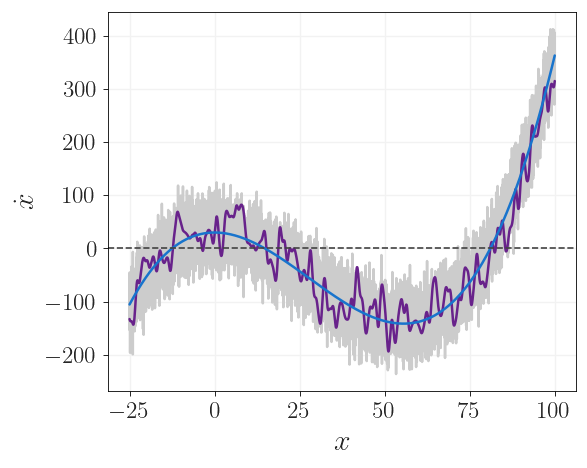

In [9]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, ax = plt.subplots(1,1, facecolor=(1,1,1), figsize=(5,4))

# Plot
ax.plot(x_range, x_dot(x_range) + wnoise[0], c="#CCCCCC")
ax.plot(x_range, x_dot(x_range) + cnoise[0][1:], c="#68228B")
ax.plot(x_range, x_dot(x_range), c="#1874CD")
ax.axhline(y=0, lw=1, ls="--", c="#424242")

# Set axis labels
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$\dot{x}$", fontsize=18)

# Cosmetic changes and axes ranges
ax.axes.grid(which="major", axis="both", c="#f2f2f2")
plt.setp(ax.spines.values(), color="black", linewidth=0.5)
ax.tick_params(
    labelsize=14,
    axis='both',          
    which='major',      
    bottom=True,
    left=True,
    color="black",
    width=0.5,
    length=3)

fig.tight_layout()

## Figure 6.4 - Autonomous states as attractors

When we think of a generative process, we can imagine that the states of the generative process change in response to something coming from outside the system being modeled. In the book the example given is a bird flapping its wings across the sky. Some force, $v$, must have set the bird into motion from its position such that the system went from being stationary to being in motion. We call this an **autonomous state**, $v$, which comes from outside the system of interest. This force may compel the system to move in a particular way to some end result. 

The simplest kind of system we can imagine for something like this is given by

$$
\begin{aligned}
    g_\mathcal{M}(x) &= x \\
    f_\mathcal{M}(x, v) &= v - x
\end{aligned}
$$

This is a generative process in state-space form, defined by two separate functions $f$ and $g$. We can see that $f$ governs how the system evolves over time and is influenced by some autonomous state $v$ which gets the system to move in a particular way. We can visualize this system with the following code.

In [10]:
# Define generating functions
def gm(x):
    return x

def fm(x, t, v):
    return v - x

In [11]:
# Define range of x and t of interest
x_range = np.arange(-20, 40, 0.01)   # First plot x-axis range
t_range = np.arange(0, 8, 0.01)       # Second plot x-axis range

# Define v, the autonomous state, and then integrate
v = 10
x_t = odeint(fm, y0=[0, 5, 15, 20], t=t_range, args=(v,))

# Find fixed points by solving for the roots
x = Symbol('x')
roots = int(Poly(x-v).nroots()[0])

<Figure size 720x480 with 0 Axes>

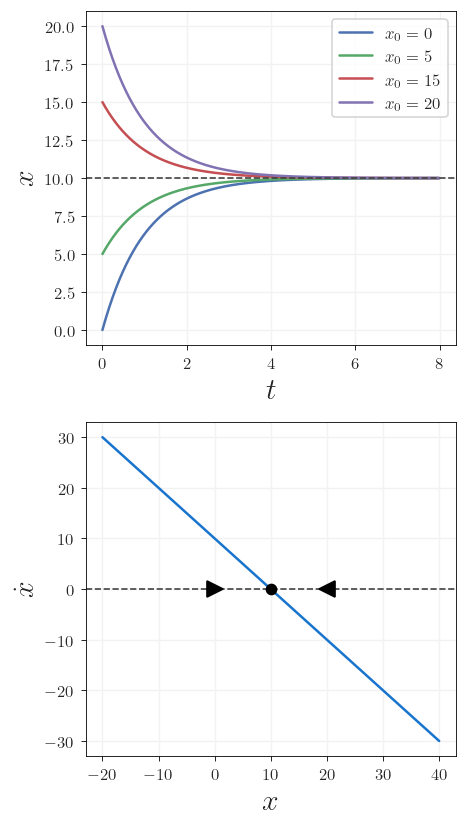

In [12]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(2, 1, facecolor=(1,1,1), figsize=(4,7))

axes[0].plot(t_range, x_t[:, 0], label=r"$x_0 = 0$")
axes[0].plot(t_range, x_t[:, 1], label=r"$x_0 = 5$")
axes[0].plot(t_range, x_t[:, 2], label=r"$x_0 = 15$")
axes[0].plot(t_range, x_t[:, 3], label=r"$x_0 = 20$")
axes[0].axhline(y=roots, lw=1, ls="--", c="#424242")

axes[1].plot(x_range, fm(x_range, t=None, v=v), c="#1874CD")
axes[1].axhline(y=0, lw=1, ls="--", c="#424242")
add_fixed_point(roots, True)
add_flows(where=[0, 20], direc=[">", "<"])

axes[0].set_xlabel(r"$t$", fontsize=18)
axes[0].set_ylabel(r"$x$", fontsize=18)
axes[1].set_xlabel(r"$x$", fontsize=18)
axes[1].set_ylabel(r"$\dot{x}$", fontsize=18)

# Subplot legends
axes[0].legend(frameon=True)

# Cosmetic changes and axes ranges
for ax in axes:
    # ax.xaxis.set_ticks(np.arange(0, 6, 1))
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)

fig.tight_layout()

This shows us the effect of the force $v$. It pulls the system toward a particular state, in this case $x=10$ which is clearly seen in the bottom panel. Autonomous states will become very important in the next chapter because they will represent the way that an agent control the environment through action.

## Figure 6.5 - The Laplace/Quadratic approximations

In many cases, we will not be interested in finding the full variational density. Instead, we may want to approximate this density with the Laplace/Quadratic approximations. The Laplace approximation, better referred to as the "Gaussian fixed-form assumption" for variational inference, assumes that the variational density is posterior. The quadratic approximation uses a second-order Taylor expansion at the posterior mode to approximate the shape of the density. This approximation gets better the more samples we have as the distribution will converge onto the posterior mode. This approximation is used frequently in the active inference literature to simplify the form of variational free energy so that the variance is a function of the mean. 

In the text, we show how to obtain the following formula for the quadratic approximation using the Taylor expansion:

$$
p(x \mid y) \approx \exp \left (\log p(\mu) + \frac{1}{2} \partial^2_{x \mid y} \log p(\mu)(x - \mu)^2 \right )
$$

This approximation gets more accurate the more samples we have. 

First, let's set up a simple environment so that we can solve for the true distribution and compare it to our approximation. In our case we are just approximating the posterior distribution not the variational density with the quadratic approximation. We will generate some data first, then define some agent's parameters. From here, we can then use the formulas for a (univariate) linear Gaussian system to get the posterior distribution parameters ($\mu_p$ and $\sigma^2_p$) and the MAP estimate $MAP_p$. Much of this code is described in more detail in Chapter 3 and the corresponding notebooks.

In [13]:
def get_posterior_statistics(var_y):
    """ Environment """
    x        = 2.                     # True x
    beta_0   = 3                      # Intercept
    beta_1   = 2                      # Slope
    mu_y     = beta_0 + beta_1 * x    # Linear generating function
    var_y    = var_y                  # Error on y

    # Generate 100 samples from Gaussian centered on y = 2x + 3
    y = Normal(                       
        loc=mu_y, 
        scale=var_y).sample([100])

    """ Agent """
    mu_x     = 2.                     # Prior mean
    var_x    = var_y                  # Prior variance

    """ Inference """
    # Compute posterior variance (var_p), posterior mean (mu_p), and MAP estimate (map_p)
    var_p    = (beta_1**2 / var_y + 1 / var_x)**(-1)
    mu_p     = var_p * (beta_1 * torch.mean(y) / var_y - (beta_0 * beta_1) / var_y + mu_x / var_y)
    map_p    = (beta_1 * (torch.mean(y) - beta_0) + mu_x) / (beta_1**2 + 1)
    return map_p, mu_x, var_x, mu_p, var_p

With the prior and posterior parameters we can create the probability density functions, `prior()` and `posterior()`. We make these a function of $\mu$ so that we can evaluate the quadratic approximation using a Taylor expansion about the mean of the distribution. Finally, the `quap()` function denotes the quadratic approximation which just implements the equation above.

In [14]:
def prior(mu):
    return Normal(loc=mu_x, scale=var_x).log_prob(mu)

def posterior(mu):
    return Normal(loc=mu_p, scale=var_p).log_prob(mu)

def quap(mu, map_p):
    H = hessian(prior, map_p)
    return torch.exp(posterior(map_p) + 0.5 * H * (mu - map_p)**2)

Now we just plot all the elements we have set up for different variances. The idea is to show that as the variance is lower, implying that we have more samples, the quadratic approximation becomes better.

In [15]:
x_range = torch.linspace(1, 3, 500)

# Quap with var_y = 1
var_y = 1
map_p, mu_x, var_x, mu_p, var_p = get_posterior_statistics(var_y)
lap_approx_1 = quap(mu=x_range, map_p=map_p)
post_1 = torch.exp(posterior(x_range))

# Quap with var_y = 0.5
var_y = 0.5
map_p, mu_x, var_x, mu_p, var_p = get_posterior_statistics(var_y)
lap_approx_2 = quap(mu=x_range, map_p=map_p)
post_2 = torch.exp(posterior(x_range))

# Quap with var_y = 0.51
var_y = 0.1
map_p, mu_x, var_x, mu_p, var_p = get_posterior_statistics(var_y)
lap_approx_3 = quap(mu=x_range, map_p=map_p)
post_3 = torch.exp(posterior(x_range))

# Quap with var_y = 0.05
var_y = 0.05
map_p, mu_x, var_x, mu_p, var_p = get_posterior_statistics(var_y)
lap_approx_4 = quap(mu=x_range, map_p=map_p)
post_4 = torch.exp(posterior(x_range))

<Figure size 720x480 with 0 Axes>

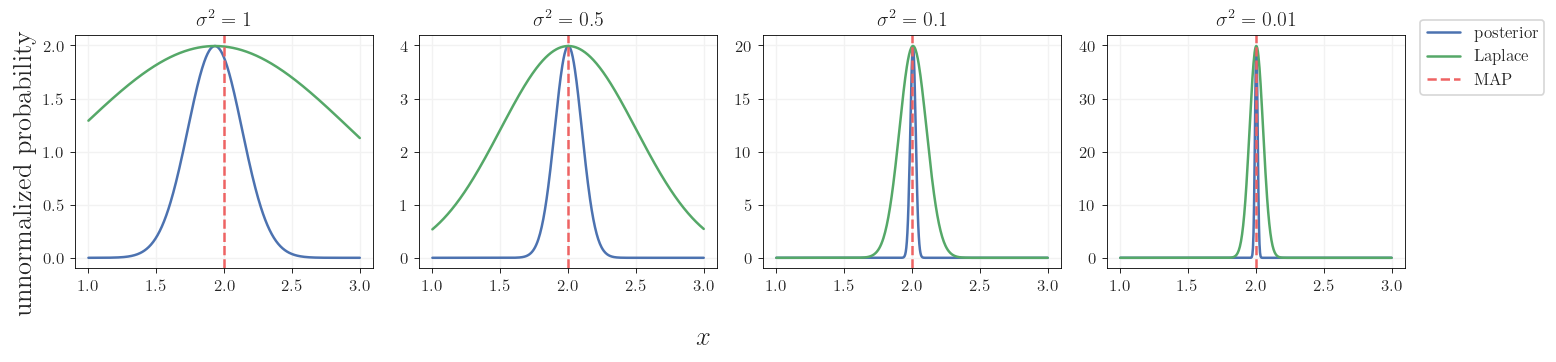

In [16]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1, 4, facecolor=(1,1,1), figsize=(12, 3))

# Plots
axes[0].plot(x_range, post_1, label=r"$\textrm{posterior}$")
axes[0].plot(x_range, lap_approx_1, label=r"$\textrm{Laplace}$")
axes[0].axvline(2, ls="--", color="#EE6363", label=r"$\textrm{MAP}$")

axes[1].plot(x_range, post_2)
axes[1].plot(x_range, lap_approx_2)
axes[1].axvline(2, ls="--", color="#EE6363")

axes[2].plot(x_range, post_3)
axes[2].plot(x_range, lap_approx_3)
axes[2].axvline(2, ls="--", color="#EE6363")

axes[3].plot(x_range, post_4)
axes[3].plot(x_range, lap_approx_4)
axes[3].axvline(2, ls="--", color="#EE6363")

# Axis global labels
fig.supxlabel(r'$x$', fontsize=16)
fig.supylabel(r'$\textrm{unnormalized probability}$', fontsize=16)

# Panel titles
axes[0].set_title(r"$\sigma^2=1$")
axes[1].set_title(r"$\sigma^2=0.5$")
axes[2].set_title(r"$\sigma^2=0.1$")
axes[3].set_title(r"$\sigma^2=0.01$")

# Cosmetic changes and axes ranges
for ax in axes:
    # ax.xaxis.set_ticks(np.arange(0, 6, 1))
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)

fig.legend(loc="upper right", bbox_to_anchor=(1.09,0.95), frameon=True)
fig.tight_layout()

## Figures 6.6-6.7 - Experiment 6A

The first aim is to set up the state space from the model and examine the generative process. In this experiment, the generative process and generative model will be identical. Starting first, we show the generative process:

$$
\mathscr{E} = \begin{cases}
    \dot{\boldsymbol{x}}^* = f_{\mathscr{E}}(\boldsymbol{x}^*, \boldsymbol{v}^*; \theta) + \omega_{x^*} & \text{State dynamics} \\
    \boldsymbol{y} = g_{\mathscr{E}}(\boldsymbol{x}^*, \boldsymbol{v}^*; \theta) + \omega_{y^*} & \text{Observation generation}
\end{cases}
$$

This generative process is defined by two separate functions:

$$
\begin{aligned}
f_{\mathscr{E}}(\boldsymbol{x}^*, \boldsymbol{v}^*; \theta) &= v^* - x^* \\
g_{\mathscr{E}}(\boldsymbol{x}^*, \boldsymbol{v}^*; \theta) &= x^* - 3
\end{aligned}
$$

Here we assume that $\theta$ (a first-order parameter) does not come into play in either equation - i.e., the function output is not controllable by any parameters. We will start with the initial condition of $x_0 = 5$. The disturbances on the process will be fixed at $v=10$. In terms of our grid, we will run the system for 10 time points with a step size of $\Delta t = 0.01$. In the code below we will run the whole generative process (rather than one time point at a time) so we can visualize it. When we begin the real simulation we will instead generate one sample at a time to mimic the relationship between the environment and the agent.

**Note**: For determining the actual trajectory of $x$ in the code below we will use the `odeint()` function from `SciPy`. When we turn to the generative model we will use the forward Euler update for the online perception process.

In [5]:
# Set up simulation space
T            = 10
dt           = 0.01
t            = np.arange(0, T, dt)
n            = len(t)

# Set up generative process hidden state and input
x_true_0     = 5    # Hidden state
v_true       = 10   # Disturbance

# Create white noise
Sigma_x_true = np.array([[0.2]])
Sigma_y_true = np.array([[0.1]])
omega_x_true = create_white_noise(sigma=Sigma_x_true, T=T, dt=dt, seed=7687)[0]
omega_y_true = create_white_noise(sigma=Sigma_y_true, T=T, dt=dt, seed=3234)[0]

# Generating functions
def fe(x, t, v):
    return v - x

def ge(x, v):
    return x - 3

# Generate data
x_true       = odeint(fe, y0=x_true_0, t=t, args=(v_true, ))[:, 0] + omega_x_true
y            = ge(x_true, v_true) + omega_y_true

<Figure size 720x480 with 0 Axes>

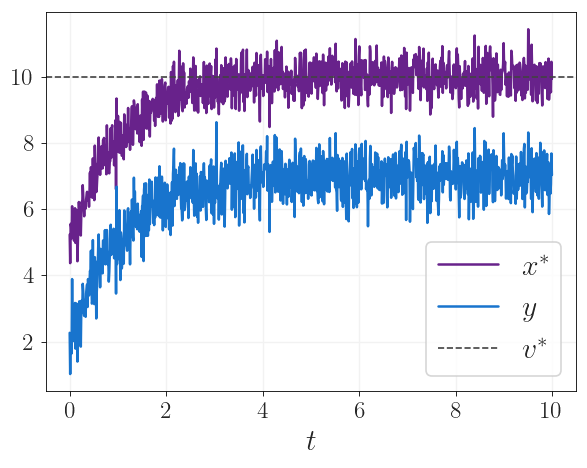

In [6]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, ax = plt.subplots(1,1, facecolor=(1,1,1), figsize=(5,4))

ax.plot(t, x_true, c="#68228B", label=r"$x^*$")
ax.plot(t, y, c="#1874CD", label=r"$y$")
ax.axhline(y=v_true, lw=1, ls="--", c="#424242", label=r"$v^*$")

# Plot labels
ax.set_xlabel(r"$t$", fontsize=18)

# Subplot legends
ax.legend(frameon=True, fontsize=18)

# Cosmetic changes and axes ranges
ax.axes.grid(which="major", axis="both", c="#f2f2f2")
plt.setp(ax.spines.values(), color="black", linewidth=0.5)
ax.tick_params(
    labelsize=14,
    axis='both',          
    which='major',      
    bottom=True,
    left=True,
    color="black",
    width=0.5,
    length=3)

fig.tight_layout()

As we can see, the generative process starts from an initial condition $x=5$ at $t=0$ and converges at the point attractor defined by $v=10$. Next we can prepare the simulation. We first need to define all of our functions of interest. First, we define the generative model functions. These will be identical to the generative process. Additionally, we will use the first derivative of `gm()` when computing the VFE gradient.

In [7]:
# Agent's generating function for x
def gm(x, v):
    return ge(x, v)

# Derivative of agent's generating function for y 
def dg_dmu(x, v):
    return 1

# Agent's generating function for x
def fm(x, v):
    t = None
    return fe(x, t, v)

Next, we need the univariate formula for variational free energy under the Laplace approximation. This is frequently referred to as the **Laplace-encoded energy**:

$$
\mathcal{F}_L = \frac{1}{2} \left (\frac{\varepsilon_x^2}{\sigma^2_x} + \frac{\varepsilon_y^2}{\sigma^2_y} + \log (\sigma^2_x \sigma^2_y) \right )
$$

We also need the gradient of $\mathcal{F}_L$ which is defined as 

$$
\frac{\partial \mathcal{F}_L}{\partial \mu_x} = \frac{\varepsilon_y}{\sigma^2_y} \frac{\partial g_{\mathcal{M}}(\mu_x,v)}{\partial \mu_x} - \frac{\varepsilon_x}{\sigma^2_x}
$$

In [8]:
# Variational free energy
def F(e_x, e_y, var_x, var_y):
    return 0.5 * ((e_x**2) / var_x + (e_y**2) / var_y + np.log(var_x * var_y))

# Partial derivative of VFE with respect to mu_x
def dvfe_dmx(x, v, e_x, e_y, var_x, var_y):
    return (e_y / var_y) * dg_dmu(x, v) - (e_x / var_x) 

Next we need to define the update rule for $\mu_x$ and our numerical integration strategy. This is given by the generic rule:

$$
\mu_x^{t+1} = \mu_x^{t} + \mathscr{U} \dot{\mu}_x
$$

Here, $\dot{\mu}$ is assumed to be a gradient descent on VFE defined as 

$$
\dot{\mu}_x = \frac{\partial \mu_x}{\partial t} = \kappa \frac{\partial F}{\partial \mu_x}
$$

with $\kappa$ as the learning rate. $\mathscr{U}$ is the step-by-step update rule for our numerical integration method of our choice. In the active inference literature $\mathscr{U}$ is chosen to be the **Okazi local linearization**, a type of exponential integrator. We will instead just use the simple Euler update in which case $\mathscr{U}$ becomes equal to our discretization interval in the simulation, $\Delta t$. Altogether the update formula becomes

$$
\mu_x^{t+1} = \mu_x^{t} + \Delta t \left ( \kappa \frac{\partial F}{\partial \mu_x} \right)
$$

In [9]:
def euler_update(mu_x, mu_v, e_x, e_y, var_x, var_y, kappa, dt):
    mu_x_dot = kappa * dvfe_dmx(mu_x, mu_v, e_x, e_y, var_x, var_y)
    return mu_x + dt * mu_x_dot

Next, we define the agent. We explain the pieces one at a time and then put the whole thing into a function that we can easily reuse for the plotting. First, we need to initialize the empty arrays to fill later with the different components of the generative model we wish to track over time. We also need to prepare the model defaults.

In [10]:
# Initialize arrays to fill
mu_x  = np.zeros(n)     # Expectation (belief) about x  [c]
mu_y  = np.zeros(n)     # Expectation (belief) about y  [d]
e_x   = np.zeros(n)     # Model prediction error
e_y   = np.zeros(n)     # Sensory prediction error
vfe   = np.zeros(n)     # Variational free energy

# Prepare inputs
mu_v  = 15              # Expected or "desired" hidden state
var_x = 1               # Prior variance        
var_y = 1               # Likelihood variance
kappa = 1               # Learning rate for gradient descent

Next, we initialize everything for the first round. We are relying on the following equations:

$$
\begin{aligned}
    \mu_x^t &= \mu_v \\
    \mu_y^t &= g_{\mathcal{M}}(\mu_x^t, \mu_v) \\
    \varepsilon_y^t &= y^t - g_{\mathcal{M}}(\mu_x^t, \mu_v) \\
    \varepsilon_x^t &= \mu_x^t - f_{\mathcal{M}}(\mu_x^t, \mu_v) \\
    \mathcal{F}_L^t &= \frac{1}{2} \left (\frac{{\varepsilon_x^t}^2}{\sigma^2_x} + \frac{{\varepsilon_y^t}^2}{\sigma^2_y} + \log (\sigma^2_x \sigma^2_y) \right )
\end{aligned}
$$

This is the initialization so $t=0$.

In [23]:
# Initialize
mu_x[0] = mu_v                           # Initial state belief (before seeing data)
mu_y[0] = gm(x=mu_x[0], v=mu_v)          # Initial observation belief (before seeing data)
e_y[0]  = y[0] - gm(mu_x[0], v=mu_v)     # Initial sensory prediction error
e_x[0]  = mu_x[0] - fm(mu_x[0], mu_v)    # Initial model prediction error
vfe[0]  = F(                             # Initial variational free energy
    e_x=e_x[0], e_y=e_y[0], 
    var_x=var_x, var_y=var_y)

Next we iterate over time and make updates to the belief about $x$ as sensory data streams in. First we use the Euler update rule to update $\mu_x$. The other pieces of the loop are identical to the initialization equations only now we are updating the value for every $t+1$ th iteration.

In [24]:
for t in range(n-1):
    # Euler's method update (via gradient descent) to mu_x
    mu_x[t+1] = euler_update(mu_x=mu_x[t], mu_v=mu_v, e_x=e_x[t], e_y=e_y[t], var_x=var_x, var_y=var_y, kappa=kappa, dt=dt)
    
    # Expected observation update given expected state update
    mu_y[t+1] =  gm(mu_x[t+1], v=mu_v)
    
    # Sensory and state prediction error updates
    e_y[t+1]  = y[t+1] - gm(mu_x[t+1], v=mu_v)
    e_x[t+1]  = mu_x[t+1] - fm(mu_x[t+1], v=mu_v)
    
    # VFE update
    vfe[t+1]  = F(e_x=e_x[t], e_y=e_y[t+1], var_x=var_x, var_y=var_y)

Putting everything together into a function we get:

In [25]:
def agent(n, var_x, var_y):
    # Initialize arrays to fill
    mu_x    = np.zeros(n)     # Expectation (belief) about x  [c]
    mu_y    = np.zeros(n)     # Expectation (belief) about y  [d]
    e_x     = np.zeros(n)     # Model prediction error
    e_y     = np.zeros(n)     # Sensory prediction error
    vfe     = np.zeros(n)     # Variational free energy

    # Prepare inputs
    mu_v    = 15              # Expected or "desired" hidden state
    var_x   = var_x           # Prior variance        
    var_y   = var_y           # Likelihood variance
    kappa   = 1               # Learning rate for gradient descent

    # Initialize
    mu_x[0] = mu_v                           # Initial state belief (before seeing data)
    mu_y[0] = gm(x=mu_x[0], v=mu_v)          # Initial observation belief (before seeing data)
    e_y[0]  = y[0] - gm(mu_x[0], v=mu_v)     # Initial sensory prediction error
    e_x[0]  = mu_x[0] - fm(mu_x[0], mu_v)    # Initial model prediction error
    vfe[0]  = F(                             # Initial variational free energy
        e_x=e_x[0], e_y=e_y[0], 
        var_x=var_x, var_y=var_y)
    
    for t in range(n-1):
        # Euler update to mu_x
        mu_x[t+1] = euler_update(mu_x=mu_x[t], mu_v=mu_v, e_x=e_x[t], e_y=e_y[t], var_x=var_x, var_y=var_y, kappa=kappa, dt=dt)
        
        # Expected observation update given expected state update
        mu_y[t+1] =  gm(mu_x[t+1], v=mu_v)
        
        # Sensory and state prediction error updates
        e_y[t+1]  = y[t +1] - gm(mu_x[t+1], v=mu_v)
        e_x[t+1]  = mu_x[t+1] - fm(mu_x[t+1], v=mu_v)
        
        # VFE update
        vfe[t+1]  = F(e_x=e_x[t], e_y=e_y[t+1], var_x=var_x, var_y=var_y)
        
    return mu_x, mu_y, e_y, e_x, vfe

Now we run the function for different variances.

In [26]:
mu_x1, mu_y1, e_y1, e_x1, vfe1 = agent(n=n, var_x=1, var_y=1)
mu_x2, mu_y2, e_y2, e_x2, vfe2 = agent(n=n, var_x=2, var_y=0.1)

<Figure size 720x480 with 0 Axes>

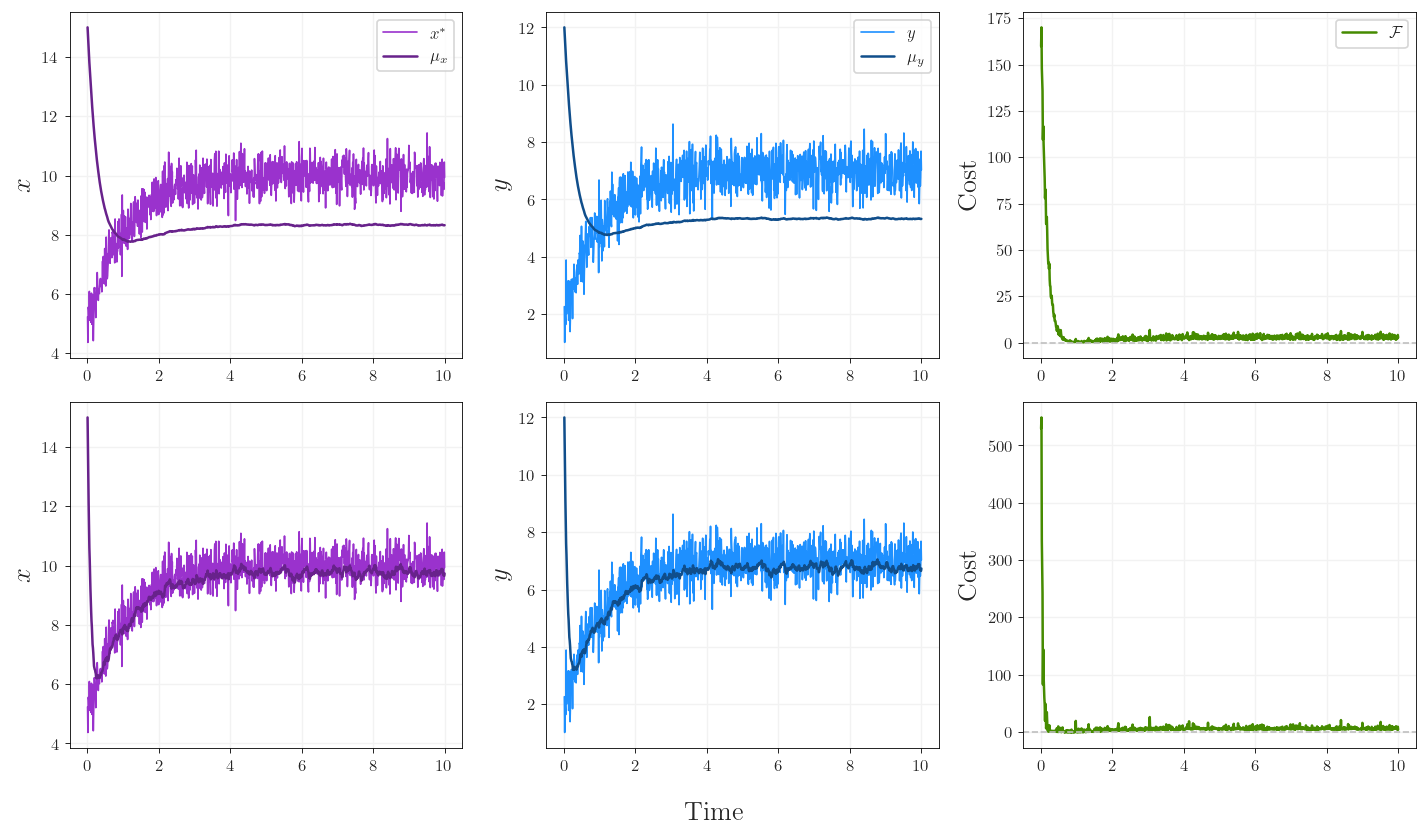

In [27]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(2,3, facecolor=(1,1,1), figsize=(12,7))

time_range = np.linspace(dt, T, n)

# x plots
axes[0, 0].plot(time_range, x_true, lw=1, c="#9A32CD", label=r"$x^*$")
axes[0, 0].plot(time_range, mu_x1, label=r"$\mu_x$", c="#68228B")
axes[1, 0].plot(time_range, x_true, lw=1, c="#9A32CD")
axes[1, 0].plot(time_range, mu_x2, c="#68228B")

# y plots
axes[0, 1].plot(time_range, y, lw=1, c="#1E90FF", label=r"$y$")         
axes[0, 1].plot(time_range, mu_y1, c="#104E8B", label=r"$\mu_y$")       
axes[1, 1].plot(time_range, y, lw=1, c="#1E90FF")
axes[1, 1].plot(time_range, mu_y2, c="#104E8B") 

# VFE plot
axes[0, 2].plot(time_range, vfe1, c="#458B00", label=r"$\mathcal{F}$")
axes[0, 2].axhline(xmin=0, xmax=T, lw=1, ls="--", c="#BFBFBF")
axes[1, 2].plot(time_range, vfe2, c="#458B00")
axes[1, 2].axhline(xmin=0, xmax=T, lw=1, ls="--", c="#BFBFBF")

# # Subplot legends
axes[0, 0].legend(frameon=True)
axes[0, 1].legend(frameon=True)
axes[0, 2].legend(frameon=True)

# Subplot labels
fig.supxlabel(r'$\textrm{Time}$', fontsize=16)
axes[0, 0].set_ylabel(r"$x$", fontsize=16)
axes[0, 1].set_ylabel(r"$y$", fontsize=16)
axes[0, 2].set_ylabel(r"$\textrm{Cost}$", fontsize=16)
axes[1, 0].set_ylabel(r"$x$", fontsize=16)
axes[1, 1].set_ylabel(r"$y$", fontsize=16)
axes[1, 2].set_ylabel(r"$\textrm{Cost}$", fontsize=16)

# # Cosmetic changes and axes ranges
for ax in axes.reshape(-1):
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)

fig.tight_layout()

## References

[1] Petzold, L. Automatic selection of methods for solving stiff and nonstiff systems of ordinary differential equations. SIAM Journal on Scientific and Statistical Computing, Vol. 4, No. 1, pp. 136-148, 1983.

[2] Hijne, I.L. Generalized motions in active inference by finite differences: active inference in robotics. Master's thesis, Delft University of Technology, 2020.